In [265]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from collections import defaultdict, namedtuple, Counter
from itertools import combinations
import numpy as np
import scipy.stats as stats
import sys
from os import listdir
import json
import argparse
import random
import scipy.sparse as sparse
import statsmodels.api as sm

sys.path.append('../../PhasingFamilies')
sys.path.append('../../PhasingFamilies/phase')
from phase.input_output import PhaseData

# Permutation Test

In [361]:
colors = ['#695d46ff', '#ce93d8ff', '#ef6c00ff', '#4db6acff']

dataset = 'ancestry'
interval = None
na = 2


In [362]:
permutation_results = '../permutation_tests/%s.%s%d' % (dataset, '' if interval is None else interval+'.', na)
mat_z = np.load('%s.mat.npy' % permutation_results)
pat_z = np.load('%s.pat.npy' % permutation_results)

mat_match = np.load('%s.mat_match.npy' % permutation_results)
pat_match = np.load('%s.pat_match.npy' % permutation_results)


with open('../permutation_tests/%s.%s%d.intervals.json' %  (dataset, '' if interval is None else interval+'.', na), 'r') as f:
    intervals = json.load(f)
num_intervals = len(intervals)

interval_starts = np.array([x['start_pos'] for x in intervals])
interval_ends = np.array([x['end_pos'] for x in intervals])
chroms = [x['chrom'] for x in intervals]

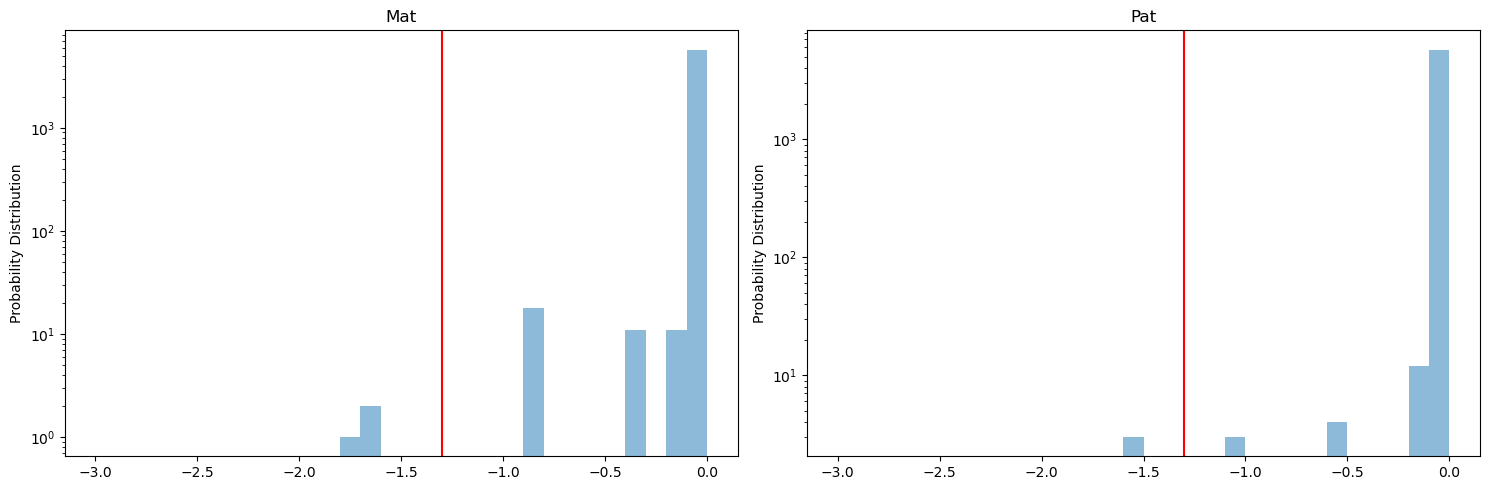

In [363]:
plt.figure(figsize=(15, 5))

bins = np.arange(-3, 0.1, 0.1)

plt.subplot(1, 2, 1)
plt.hist(np.clip(np.log10(mat_z), -3, None), alpha=0.5, bins=bins, log=True)
plt.axvline(np.log10(0.05), color='red')
plt.ylabel('Probability Distribution')
plt.title('Mat')

plt.subplot(1, 2, 2)
plt.hist(np.clip(np.log10(pat_z), -3, None), alpha=0.5, bins=bins, log=True)
plt.axvline(np.log10(0.05), color='red')
plt.ylabel('Probability Distribution')
plt.title('Pat')

plt.tight_layout()
plt.show()

In [364]:
print(np.min(mat_z), np.min(pat_z))


0.019 0.026


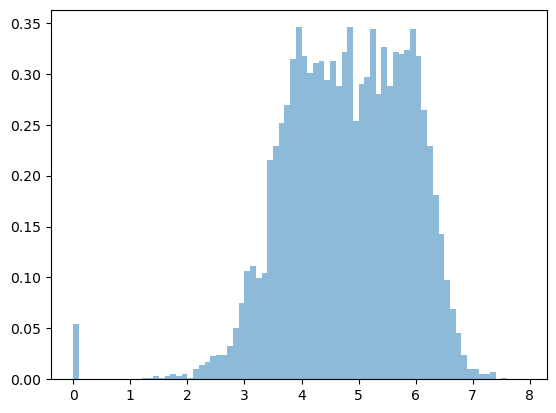

In [365]:
plt.hist(np.log10(interval_ends-interval_starts), 
         bins=np.arange(0, 8, 0.1), alpha=0.5, density=True)

plt.show()

In [366]:
with open('../data/chrom_lengths38.json', 'r') as f:
    chrom_lengths = json.load(f)
offset = np.zeros((24,), dtype=int)
for ch in range(1, 24):
    offset[(ch+1):] += chrom_lengths['X' if ch==23 else str(ch)]

x = np.array([offset[int(ch)]+p for ch, p in zip(chroms, interval_starts)])


In [367]:
print('aut-aut mat')
indices = np.where(-np.log10(mat_z) >= -np.log10(0.05))[0]
print('\n'.join(['%s:%d-%d\t%0.3f' % (chroms[i], interval_starts[i], interval_ends[i], mat_z[i]) for i in indices]))

print('aut-aut pat')
indices = np.where(-np.log10(pat_z) >= -np.log10(0.05))[0]
print('\n'.join(['%s:%d-%d\t%0.3f' % (chroms[i], interval_starts[i], interval_ends[i], pat_z[i]) for i in indices]))

aut-aut mat
19:3604269-3646645	0.020
19:3646645-3709068	0.019
19:3709068-3718439	0.020
aut-aut pat
7:4101620-4106985	0.027
7:4106985-4745023	0.026
7:4745023-4747462	0.027


In [368]:
print(3718439-3604269)
print(4747462-4101620)

114170
645842


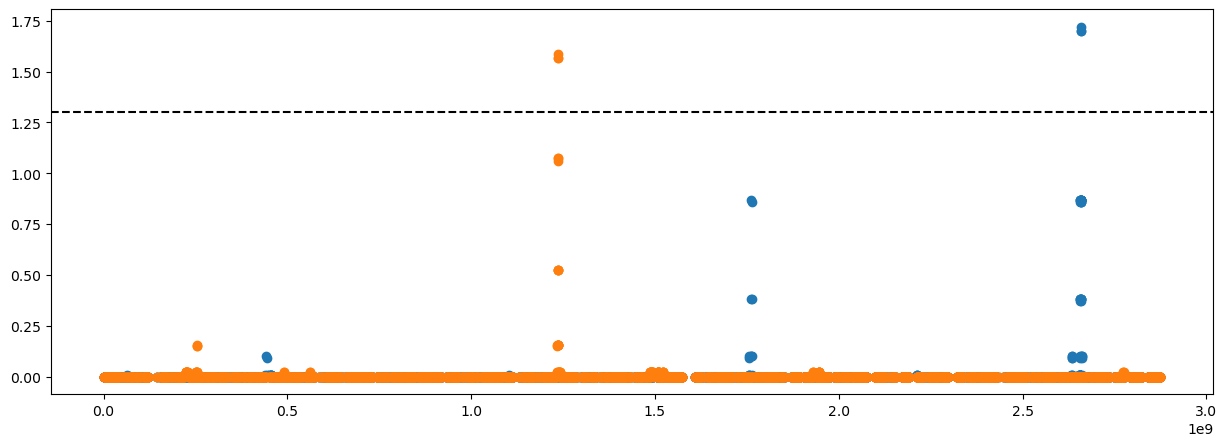

In [369]:
plt.figure(figsize=(15, 5))
plt.scatter(x, -np.log10(mat_z))
plt.scatter(x, -np.log10(pat_z))
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.show()

In [370]:
mat_cutoff = np.min(mat_match[mat_z<=0.05])
pat_cutoff = np.min(pat_match[pat_z<=0.05])

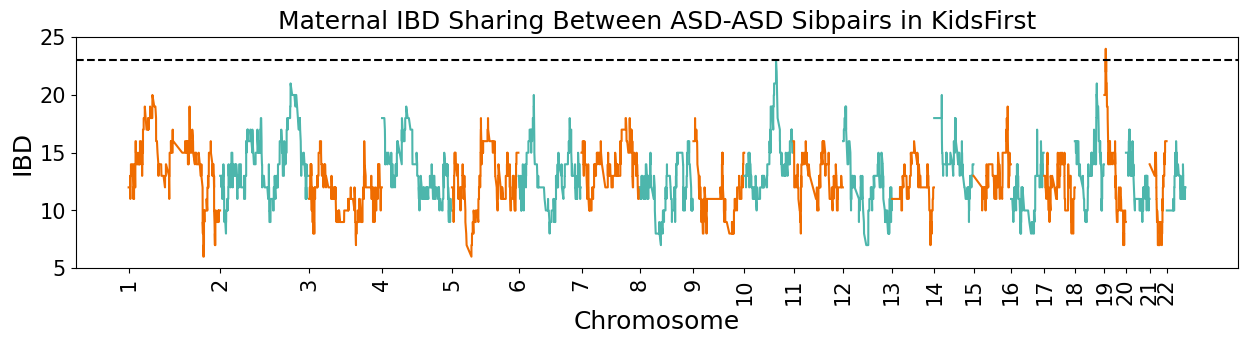

In [382]:
plt.figure(figsize=(15, 3))
for i, chrom in enumerate([str(x) for x in range(1, 23)]):
    is_chrom = np.array([c==chrom for c in chroms])
    plt.plot(x[is_chrom], mat_match[is_chrom], color=colors[(i%2)+2])
plt.axhline(mat_cutoff, color='black', linestyle='--')
plt.xticks(offset[1:-1], [str(x) for x in range(1, 23)], fontsize=15, rotation=90)
plt.yticks(np.arange(5, 30, 5), fontsize=15)
plt.ylabel('IBD', fontsize=18)
plt.xlabel('Chromosome', fontsize=18)

plt.title('Maternal IBD Sharing Between ASD-ASD Sibpairs in KidsFirst', fontsize=18)

plt.savefig('../plots/ibd_mat.png', bbox_inches="tight")

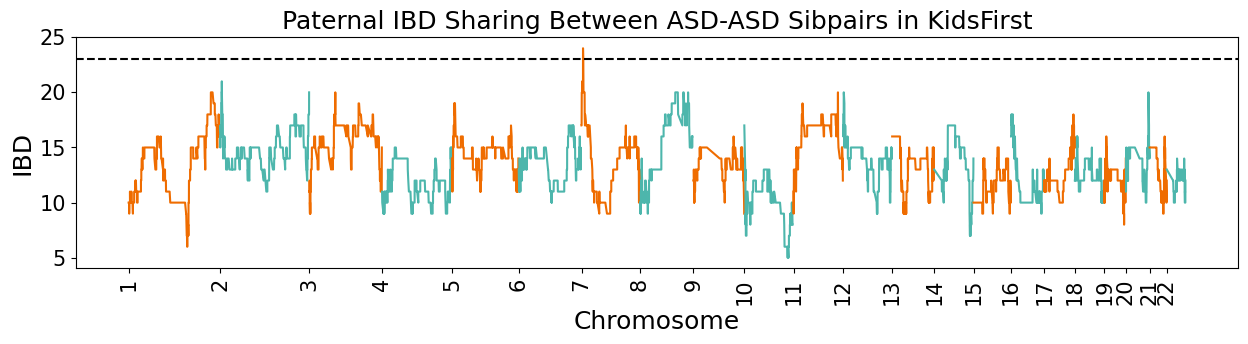

In [381]:
plt.figure(figsize=(15, 3))
for i, chrom in enumerate([str(x) for x in range(1, 23)]):
    is_chrom = np.array([c==chrom for c in chroms])
    plt.plot(x[is_chrom], pat_match[is_chrom], color=colors[(i%2)+2])
plt.axhline(pat_cutoff, color='black', linestyle='--')
plt.xticks(offset[1:-1], [str(x) for x in range(1, 23)], fontsize=15, rotation=90)
plt.yticks(np.arange(5, 30, 5), fontsize=15)
plt.ylabel('IBD', fontsize=18)
plt.xlabel('Chromosome', fontsize=18)
plt.title('Paternal IBD Sharing Between ASD-ASD Sibpairs in KidsFirst', fontsize=18)
plt.savefig('../plots/ibd_pat.png', bbox_inches="tight")

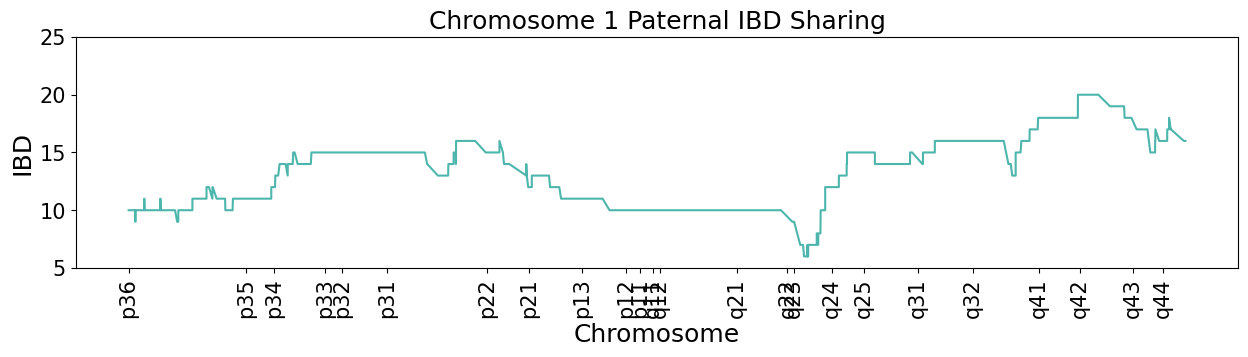

In [380]:
cyto_start_pos, cyto_end_pos, cyto_label = [], [], []
with open('../data/cytoband38.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0]=='chr1':
            if len(cyto_label)==0 or cyto_label[-1].split('.')[0] != pieces[3].split('.')[0]:
                cyto_start_pos.append(int(pieces[1]))
                cyto_end_pos.append(int(pieces[2]))
                cyto_label.append(pieces[3].split('.')[0])
    
    
plt.figure(figsize=(15, 3))
is_chrom = np.array([c=='1' for c in chroms])
plt.plot(x[is_chrom], pat_match[is_chrom], color=colors[(i%2)+2])
#plt.axhline(pat_cutoff, color='black', linestyle='--')
plt.xticks(cyto_start_pos, cyto_label, fontsize=15, rotation=90)
plt.yticks(np.arange(5, 30, 5), fontsize=15)
plt.ylabel('IBD', fontsize=18)
plt.xlabel('Chromosome', fontsize=18)
plt.title('Chromosome 1 Paternal IBD Sharing', fontsize=18)
plt.savefig('../plots/neighbors.png', bbox_inches="tight")

# Look at relationship between the two regions

In [344]:
chrom1, start_pos1, end_pos1 = '19', 3604269, 3718439
chrom2, start_pos2, end_pos2 = '7', 4101620, 4747462
na = 2
#chrom2, start_pos2, end_pos2 = '7', 0, 10000000

def pull_data(dataset):
    interval1 = '%s.%d-%d' % (chrom1, start_pos1, end_pos1)
    interval2 = '%s.%d-%d' % (chrom2, start_pos2, end_pos2)

    is_mat_match1 = np.load('../permutation_tests/%s.%s.%d.is_mat_match.npy' % (dataset, interval1, na))
    is_pat_match2 = np.load('../permutation_tests/%s.%s.%d.is_pat_match.npy' % (dataset, interval2, na))

    with open('../permutation_tests/%s.%s.%d.intervals.json' %  (dataset, interval1, na), 'r') as f:
        intervals1 = json.load(f)
    interval_starts1 = np.array([x['start_pos'] for x in intervals1])
    interval_ends1 = np.array([x['end_pos'] for x in intervals1])
    chroms1 = [x['chrom'] for x in intervals1]

    with open('../permutation_tests/%s.%s.%d.intervals.json' %  (dataset, interval2, na), 'r') as f:
        intervals2 = json.load(f)
    interval_starts2 = np.array([x['start_pos'] for x in intervals2])
    interval_ends2 = np.array([x['end_pos'] for x in intervals2])
    chroms2 = [x['chrom'] for x in intervals2]

    is_match1 = np.zeros((is_mat_match1.shape[0],), dtype=int)
    is_match1[np.all(is_mat_match1>=0, axis=1)] = 1
    is_match1[np.all(is_mat_match1<=0, axis=1)] = -1

    is_match2 = np.zeros((is_pat_match2.shape[0],), dtype=int)
    is_match2[np.all(is_pat_match2>=0, axis=1)] = 1
    is_match2[np.all(is_pat_match2<=0, axis=1)] = -1

    print(np.sum(is_match1==0)/is_match1.shape[0], np.sum(is_match2==0)/is_match1.shape[0])

    c = [[np.sum((is_match1==1) & (is_match2==1)), 
          np.sum((is_match1==1) & (is_match2==-1))],
         [np.sum((is_match1==-1) & (is_match2==1)), 
          np.sum((is_match1==-1) & (is_match2==-1))]]
    print(c)

    print(stats.chi2_contingency(c))
    print(stats.binom_test(np.sum(is_match1==1), np.sum(is_match1!=0), alternative='greater'))
    print(stats.binom_test(np.sum(is_match2==1), np.sum(is_match2!=0), alternative='greater'))
    return interval_starts1, interval_starts2, is_mat_match1, is_pat_match2, is_match1, is_match2

interval_starts1_ancestry, interval_starts2_ancestry, is_mat_match1_ancestry, is_pat_match2_ancestry, is_match1_ancestry, is_match2_ancestry = pull_data('ancestry')
interval_starts1_spark, interval_starts2_spark, is_mat_match1_spark, is_pat_match2_spark, is_match1_spark, is_match2_spark = pull_data('spark')
#interval_starts1_ihart, interval_starts2_ihart, is_mat_match1_ihart, is_pat_match2_ihart, is_match1, is_match2 = pull_data('ihart.ms2')


0.0 0.0
[[22, 2], [2, 0]]
Chi2ContingencyResult(statistic=0.0, pvalue=1.0, dof=1, expected_freq=array([[22.15384615,  1.84615385],
       [ 1.84615385,  0.15384615]]))
5.245208740234375e-06
5.245208740234375e-06
0.0 0.04220558202859088
[[392, 334], [330, 351]]
Chi2ContingencyResult(statistic=4.092415998089865, pvalue=0.04307602712913971, dof=1, expected_freq=array([[372.54584222, 353.45415778],
       [349.45415778, 331.54584222]]))
0.07198239670957939
0.16859315292676183


/var/folders/hp/72rjd_x140qf9f9d9f4hy40c0000gp/T/ipykernel_32990/1981520842.py:42: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  print(stats.binom_test(np.sum(is_match1==1), np.sum(is_match1!=0), alternative='greater'))
/var/folders/hp/72rjd_x140qf9f9d9f4hy40c0000gp/T/ipykernel_32990/1981520842.py:43: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  print(stats.binom_test(np.sum(is_match2==1), np.sum(is_match2!=0), alternative='greater'))


BinomTestResult(k=763, n=1469, alternative='greater', statistic=0.5194009530292716, pvalue=0.07198239670957939)
BinomTestResult(k=722, n=1407, alternative='greater', statistic=0.5131485429992892, pvalue=0.16859315292676183)
BinomTestResult(k=392, n=1407, alternative='greater', statistic=0.27860696517412936, pvalue=0.0076912444142808005)


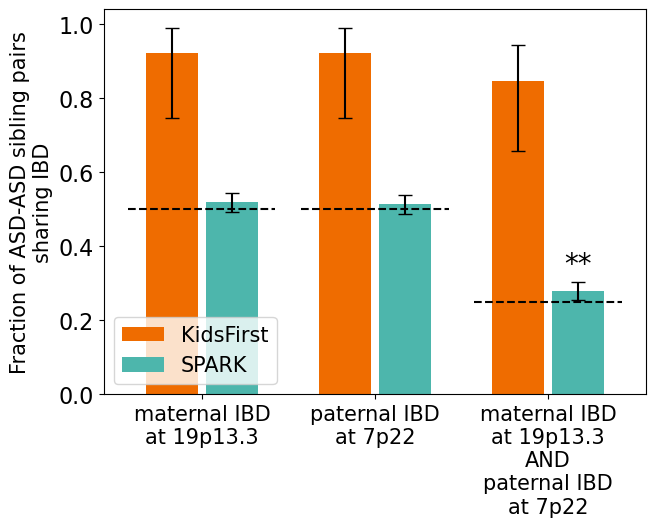

In [348]:
plt.figure(figsize=(7, 5))

anc_ns = np.array([np.sum(is_match1_ancestry==1), np.sum(is_match2_ancestry==1), np.sum((is_match1_ancestry==1) & (is_match2_ancestry==1))])
anc_ds = np.array([np.sum(is_match1_ancestry!=0), np.sum(is_match2_ancestry!=0), np.sum((is_match1_ancestry!=0) & (is_match2_ancestry!=0))])
anc_ps = anc_ns/anc_ds

plt.bar(np.arange(3), anc_ps, width=0.3, color=colors[2], label='KidsFirst')
anc_lb, anc_ub = sm.stats.proportion_confint(anc_ns, anc_ds, alpha=0.05, method='agresti_coull')
plt.errorbar(np.arange(3), anc_ps, yerr=[anc_ps-anc_lb, anc_ub-anc_ps], 
                 color='black', linestyle='', capsize=5)

spa_ns = np.array([np.sum(is_match1_spark==1), np.sum(is_match2_spark==1), np.sum((is_match1_spark==1) & (is_match2_spark==1))])
spa_ds = np.array([np.sum(is_match1_spark!=0), np.sum(is_match2_spark!=0), np.sum((is_match1_spark!=0) & (is_match2_spark!=0))])
spa_ps = spa_ns/spa_ds
plt.bar(np.arange(3)+0.35, spa_ps, width=0.3, color=colors[3], label='SPARK')
spa_lb, spa_ub = sm.stats.proportion_confint(spa_ns, spa_ds, alpha=0.05, method='agresti_coull')
plt.errorbar(np.arange(3)+0.35, spa_ps, yerr=[spa_ps-spa_lb, spa_ub-spa_ps], 
                 color='black', linestyle='', capsize=5)

for i, p in enumerate([0.5, 0.5, 0.25]):
    result = stats.binomtest(spa_ns[i], spa_ds[i], p=p, alternative='greater')
    print(result)
    if result.pvalue<0.05:
        plt.text(i+0.35, 0.35, '***' if result.pvalue<0.001 else '**' if result.pvalue<0.01 else '*', fontsize=20, ha='center', va='center')


plt.plot([-0.25, 0.6], [0.5, 0.5], color='black', linestyle='--')
plt.plot([0.75, 1.6], [0.5, 0.5], color='black', linestyle='--')
plt.plot([1.75, 2.6], [0.25, 0.25], color='black', linestyle='--')
plt.xticks(np.arange(3)+0.175, ['maternal IBD\nat 19p13.3', 'paternal IBD\nat 7p22', 'maternal IBD\nat 19p13.3\nAND\npaternal IBD\nat 7p22'],
          fontsize=15)
plt.yticks(fontsize=16)
plt.ylabel('Fraction of ASD-ASD sibling pairs\nsharing IBD', fontsize=15)

plt.legend(fontsize=15)
    
plt.savefig('../plots/spark_val.png', bbox_inches="tight")